In [17]:
import functools
import random

import numpy as np
import pandas as pd
from cachetools import LFUCache, LRUCache, FIFOCache, RRCache, Cache
from matplotlib import pyplot as plt
import pandas as pd

from benchmark.beladycache import BeladyCache
from benchmark.fixcache import AllowCache
from mlfucache import MLFUCache

In [18]:
n = 100000
cbase = n // 100
size = cbase // 20

In [19]:
s = 1.1
HNs = sum([k ** -s for k in range(1, cbase + 1)])


def zipf_pmf(k, s):
    return sum([k ** -s / HNs])


p = 0.01


def geometric_pmf(k, p):
    assert 0 < p <= 1
    return (1 - p) ** (k - 1) * p


keys = range(1, cbase + 1)


In [20]:
def mycached(cache: Cache):
    def decorator(func):
        hits = np.ndarray(shape=(0, 2))

        def wrapper(timestamp, key):
            nonlocal hits
            try:
                if isinstance(cache, BeladyCache):
                    # update time for Bélády
                    cache.time = timestamp

                result = cache[key]
                hits = np.append(hits, [[key, True]], axis=0)
                return result
            except KeyError:
                hits = np.append(hits, [[key, False]], axis=0)
            v = func(timestamp, key)
            try:
                cache[key] = v
            except ValueError:
                pass  # value too large
            return v

        def cache_clear() -> None:
            nonlocal hits
            cache.clear()
            hits = np.ndarray(shape=(0, 2))

        def nrequests() -> int:
            nonlocal hits
            return len(hits)

        def df() -> pd.DataFrame:
            nonlocal hits
            return pd.DataFrame({'key': hits[:, 0].astype(int), 'hit': hits[:, 1].astype(bool)}).set_index('key')

        wrapper.cache = cache
        wrapper.cache_clear = cache_clear
        wrapper.nrequests = nrequests
        wrapper.df = df
        #        wrapper.cache_info = cache_info

        return functools.update_wrapper(wrapper, func)

    return decorator

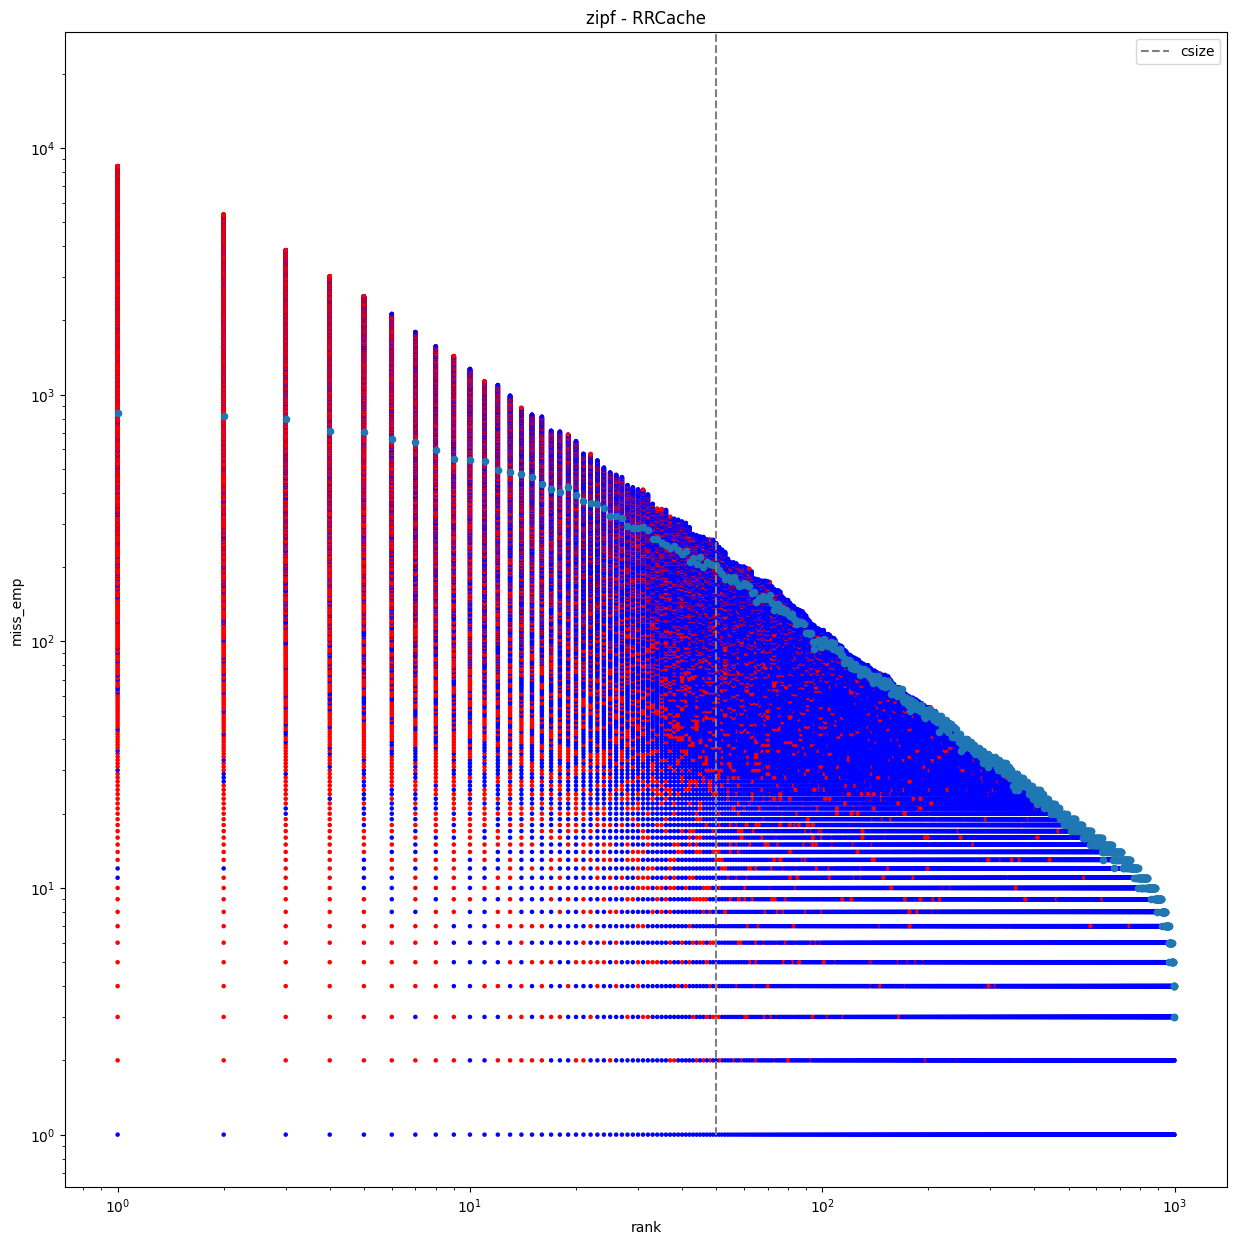

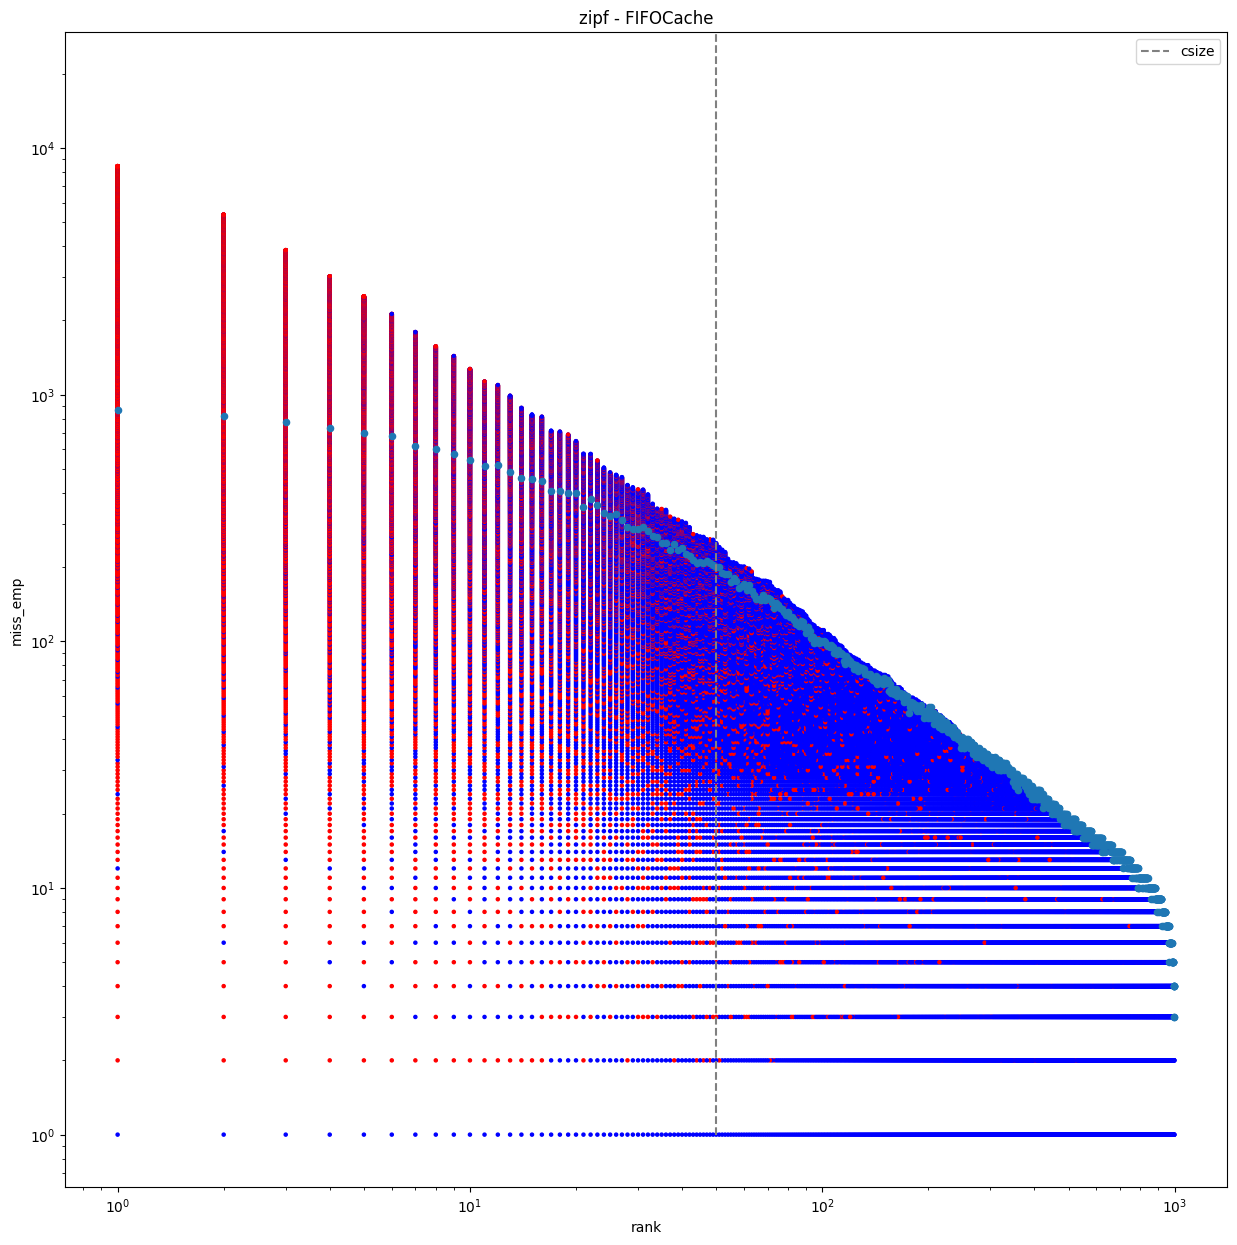

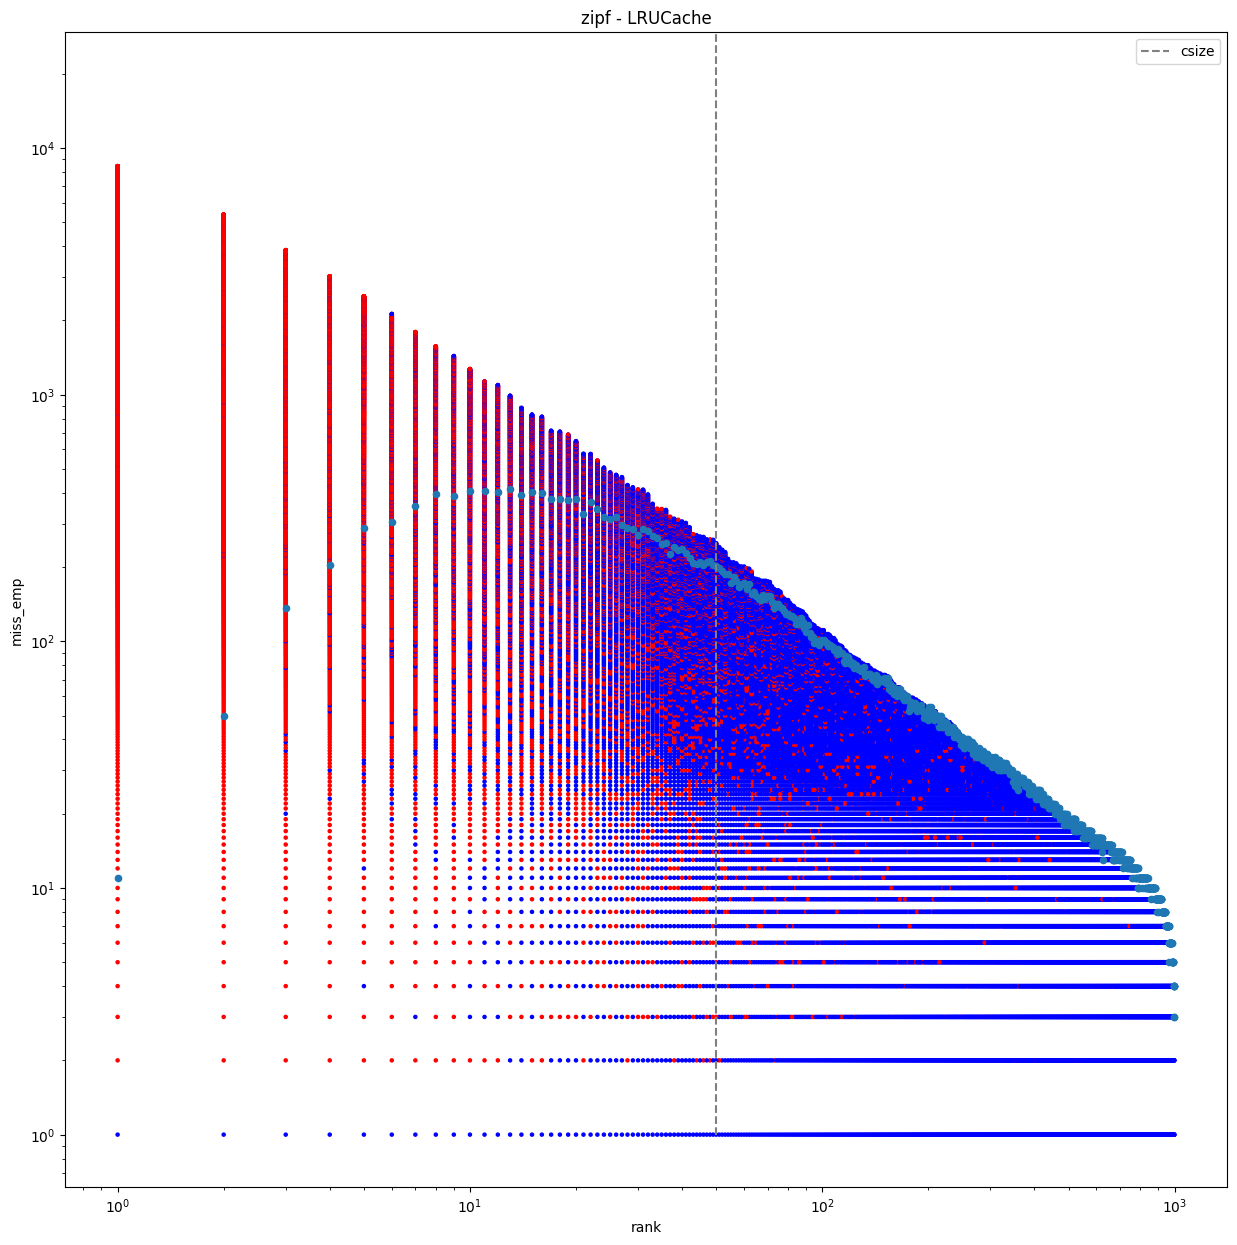

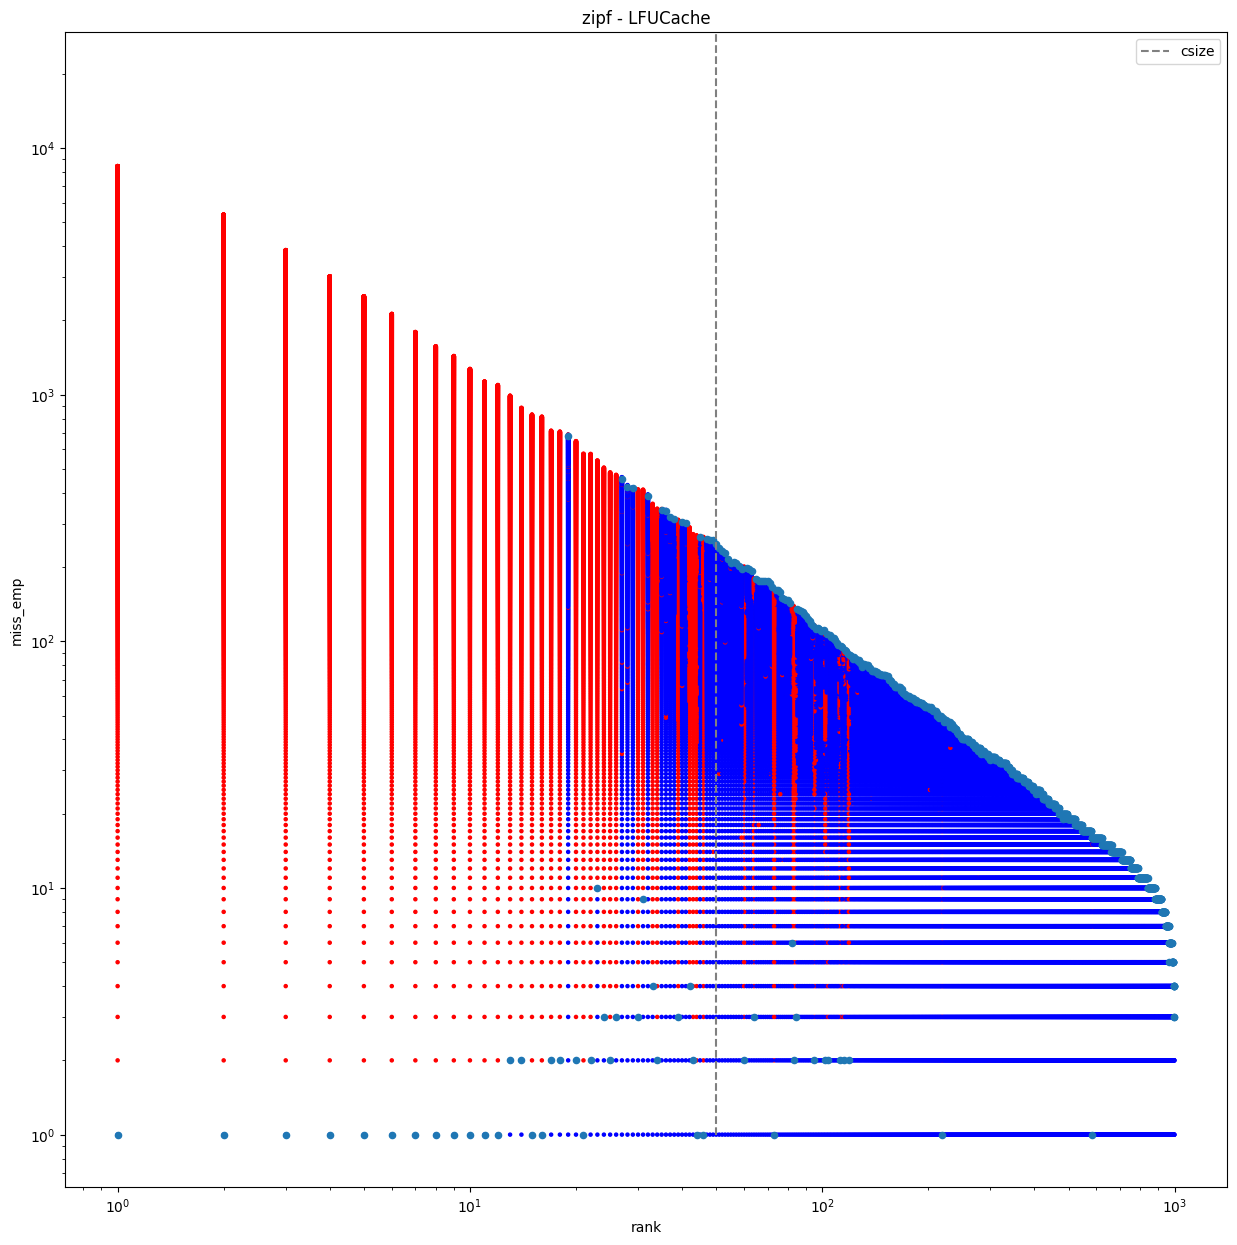

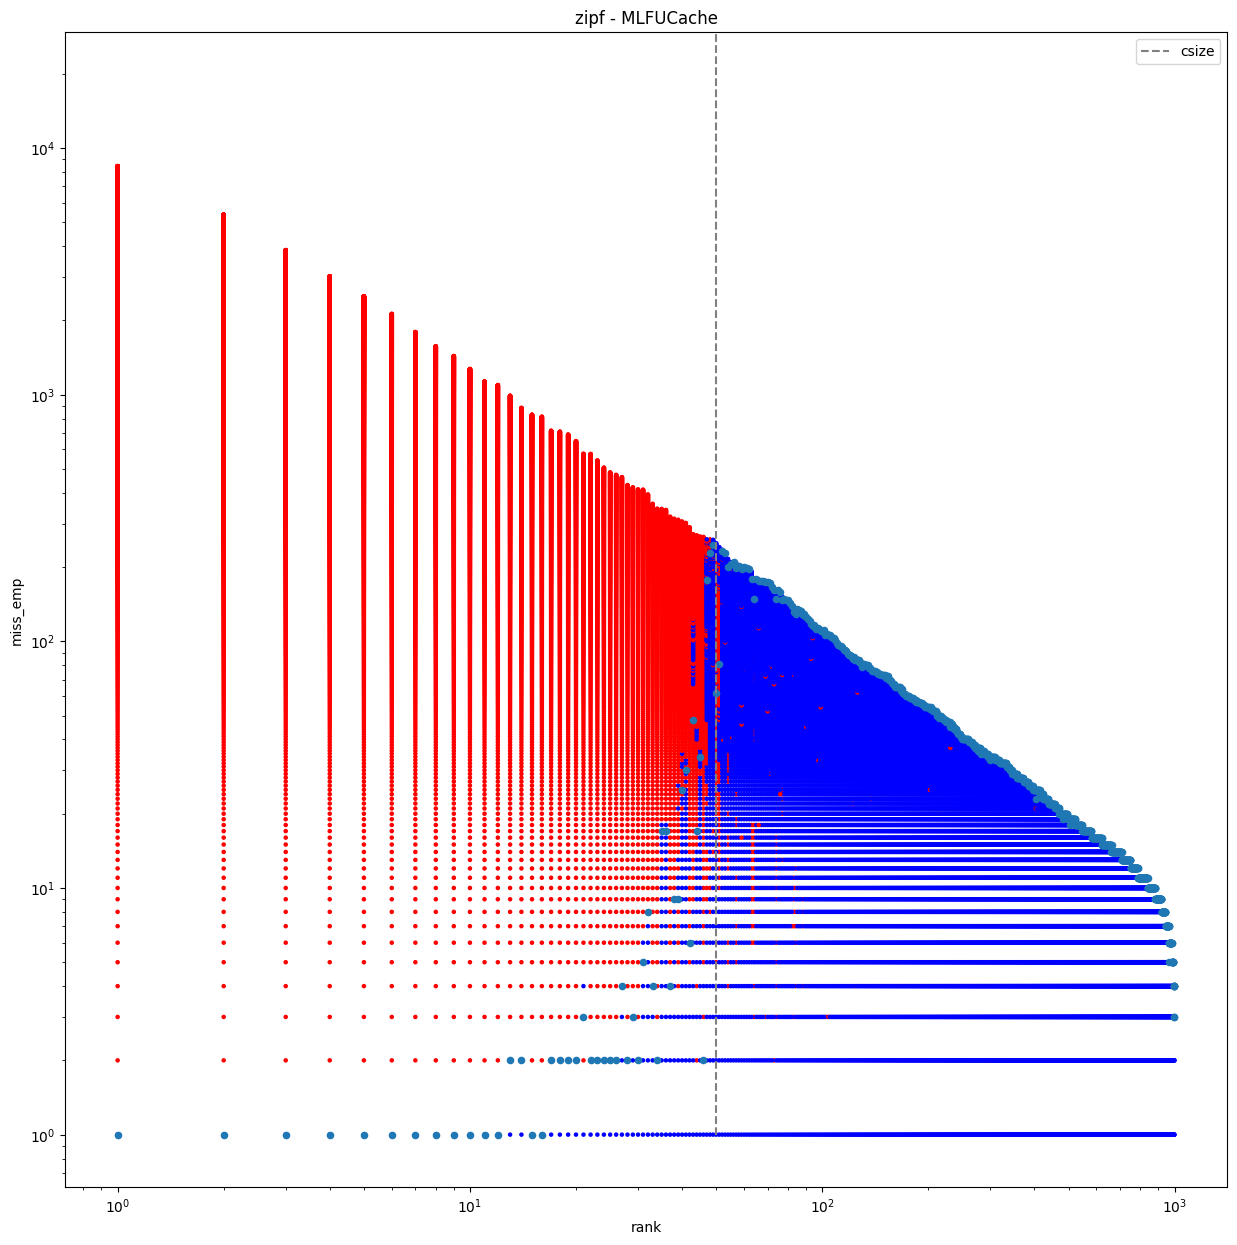

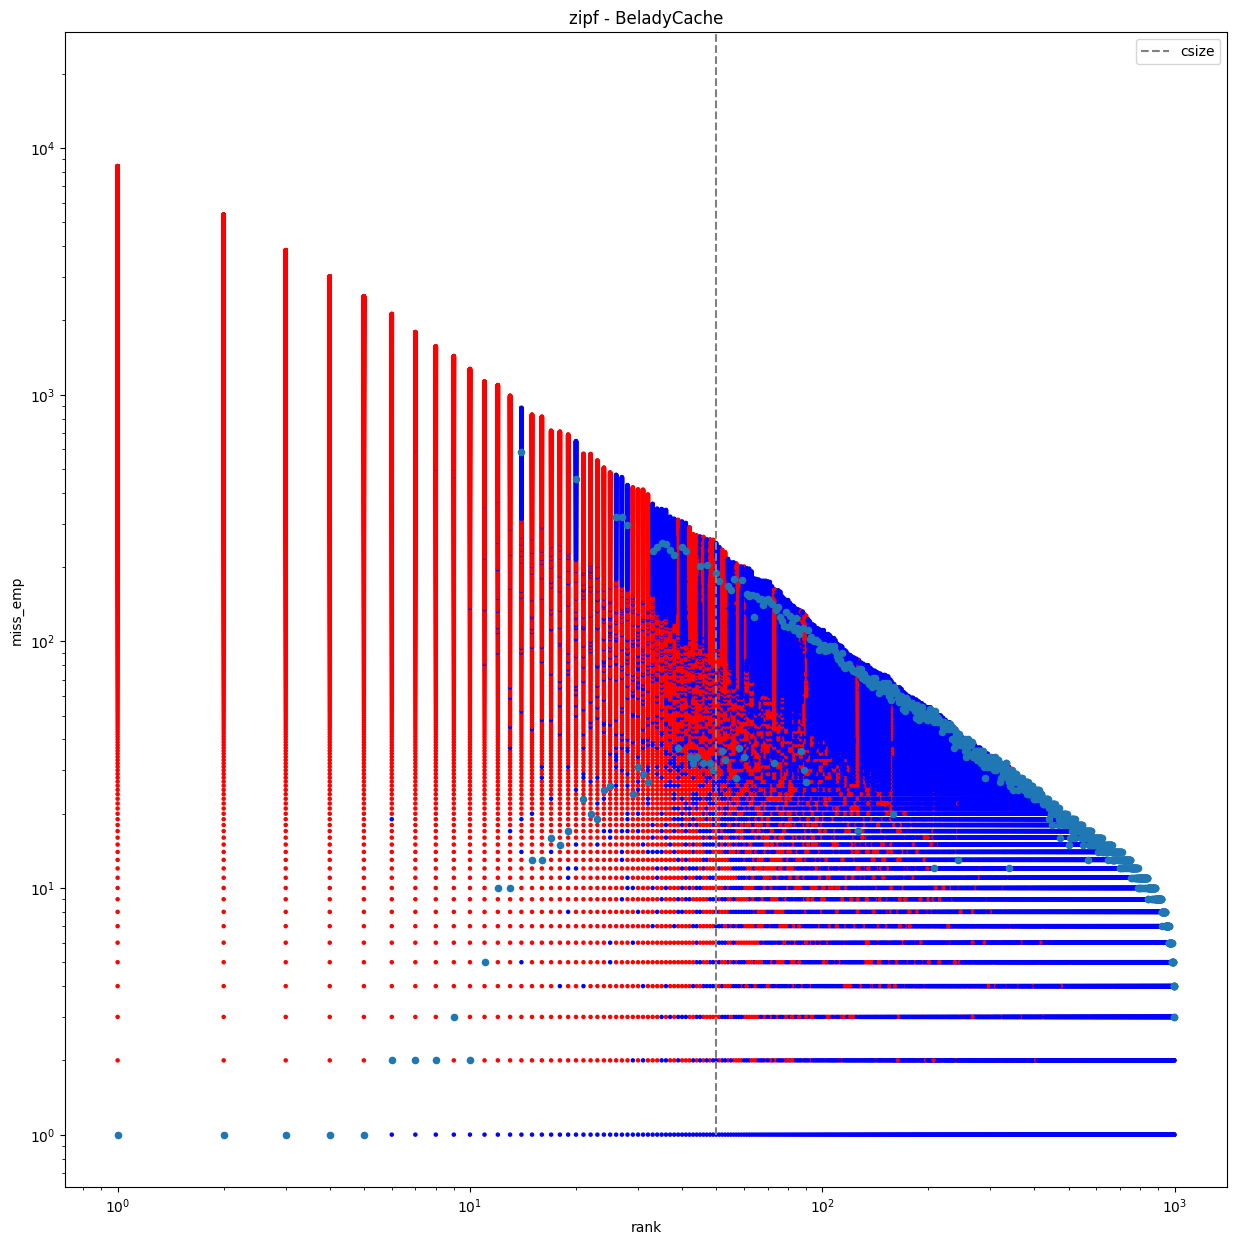

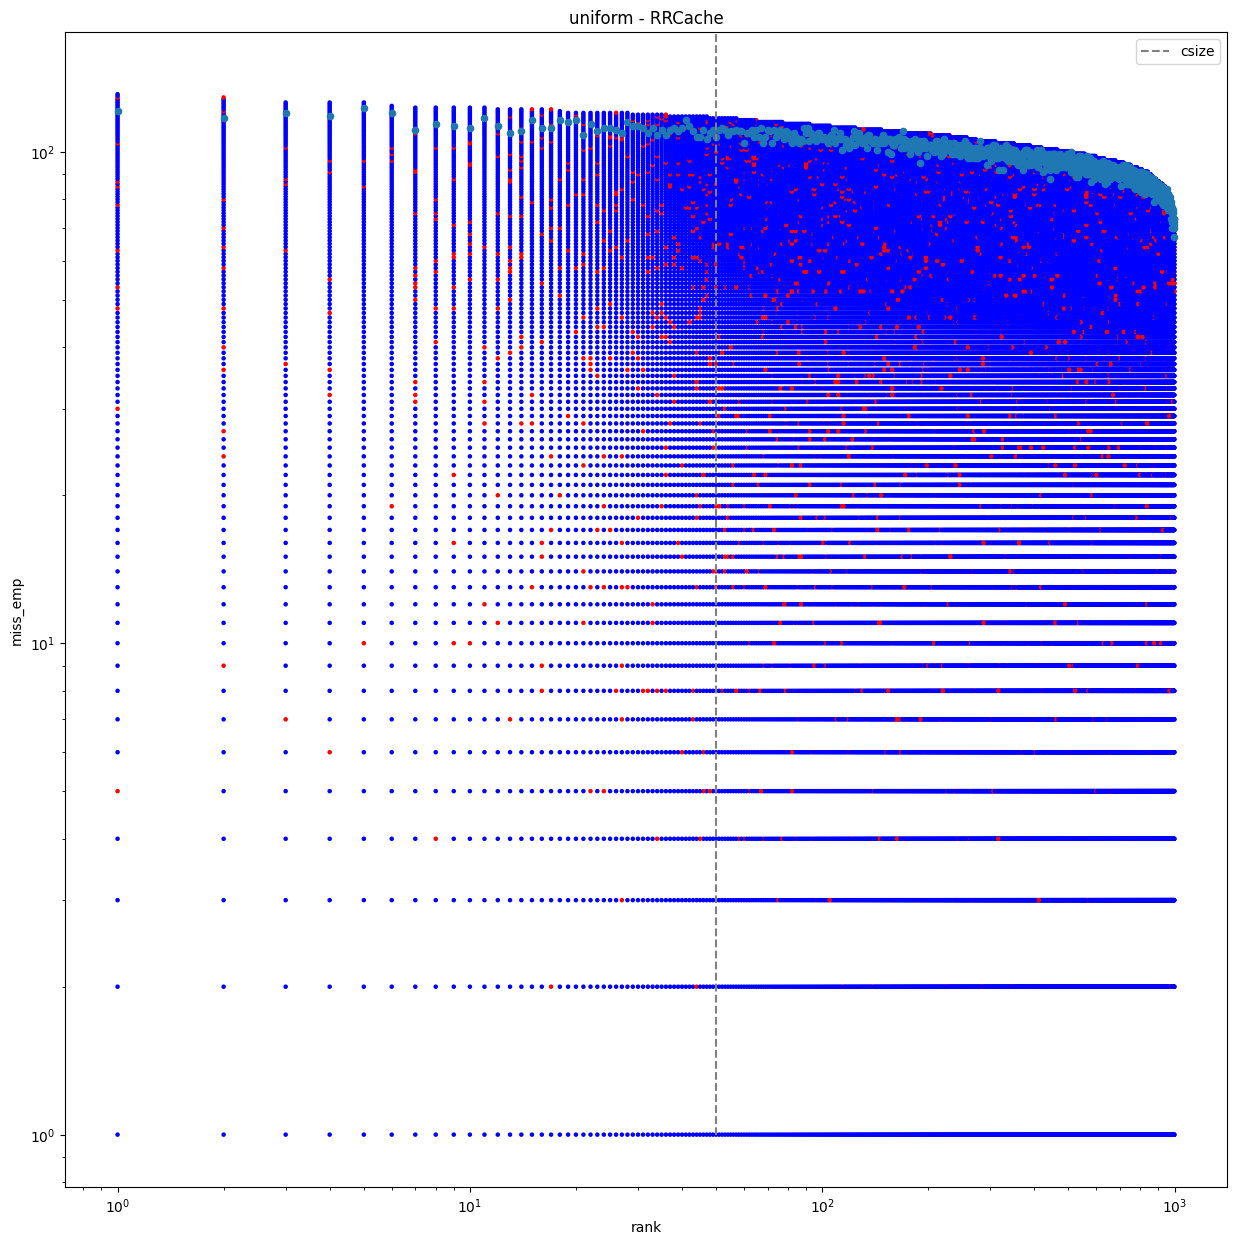

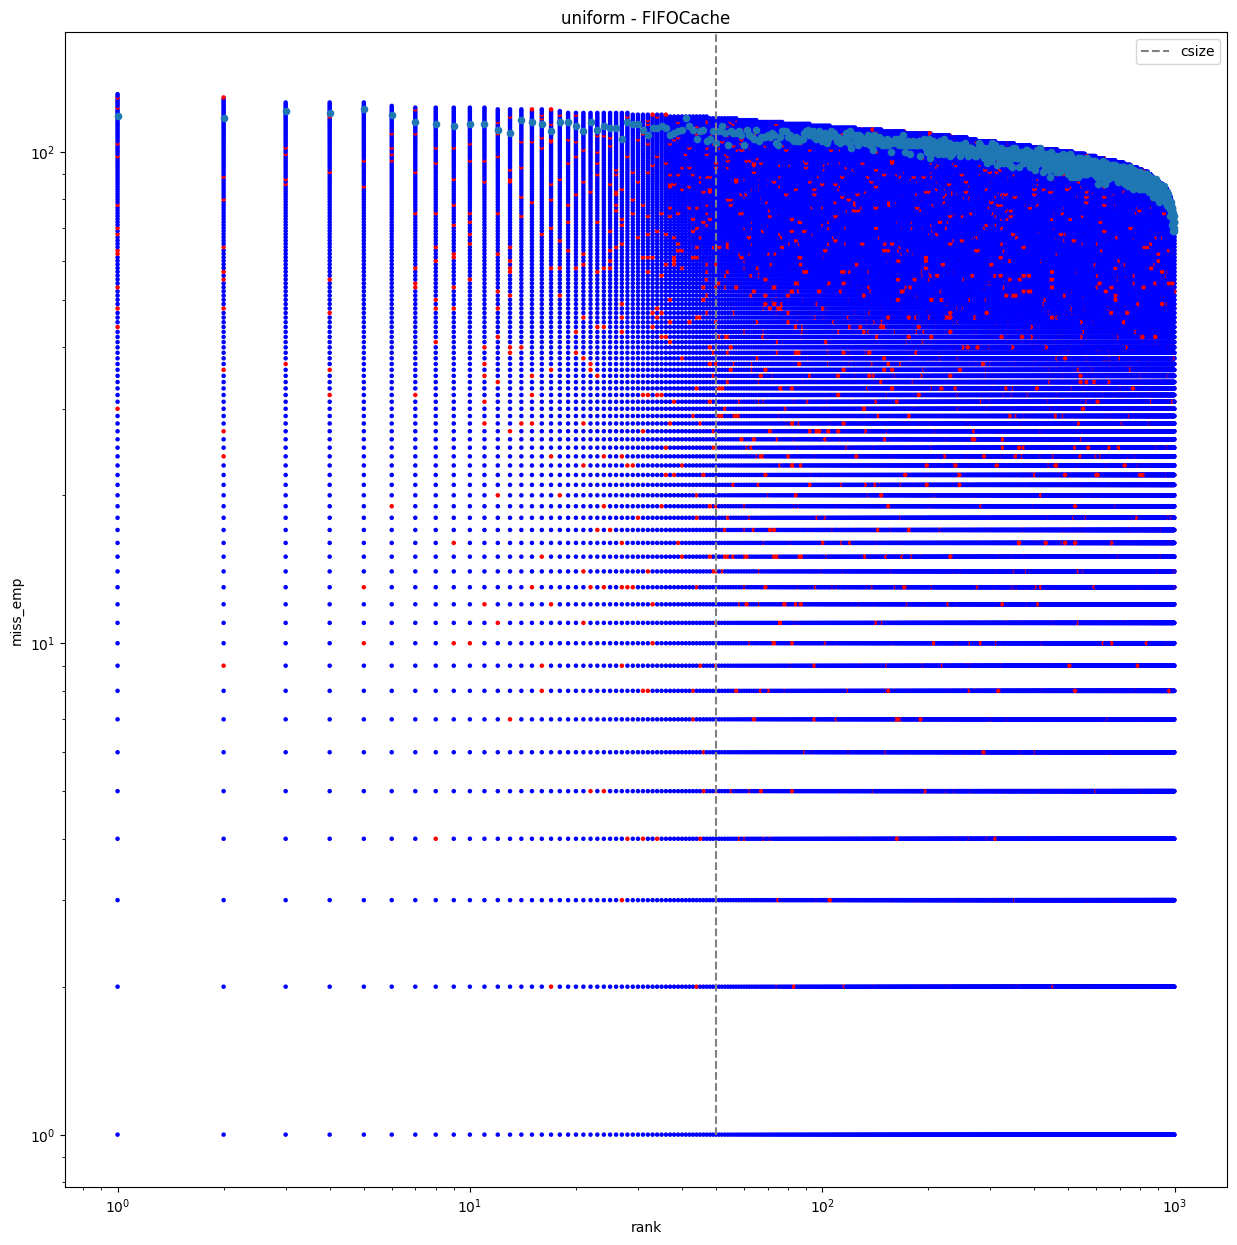

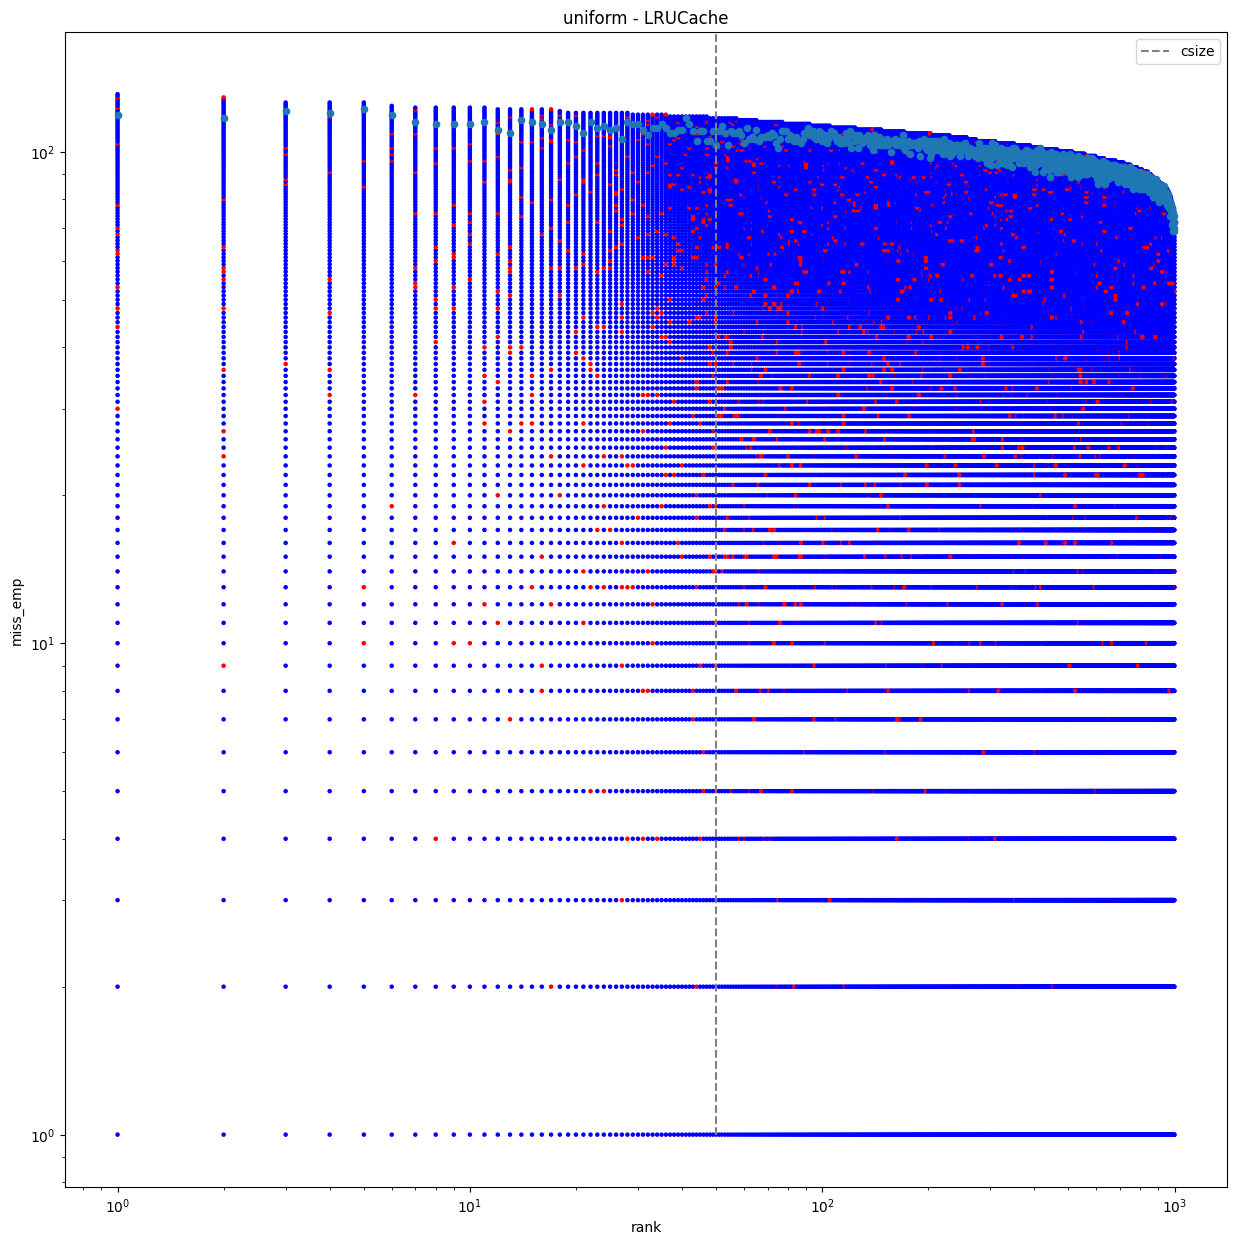

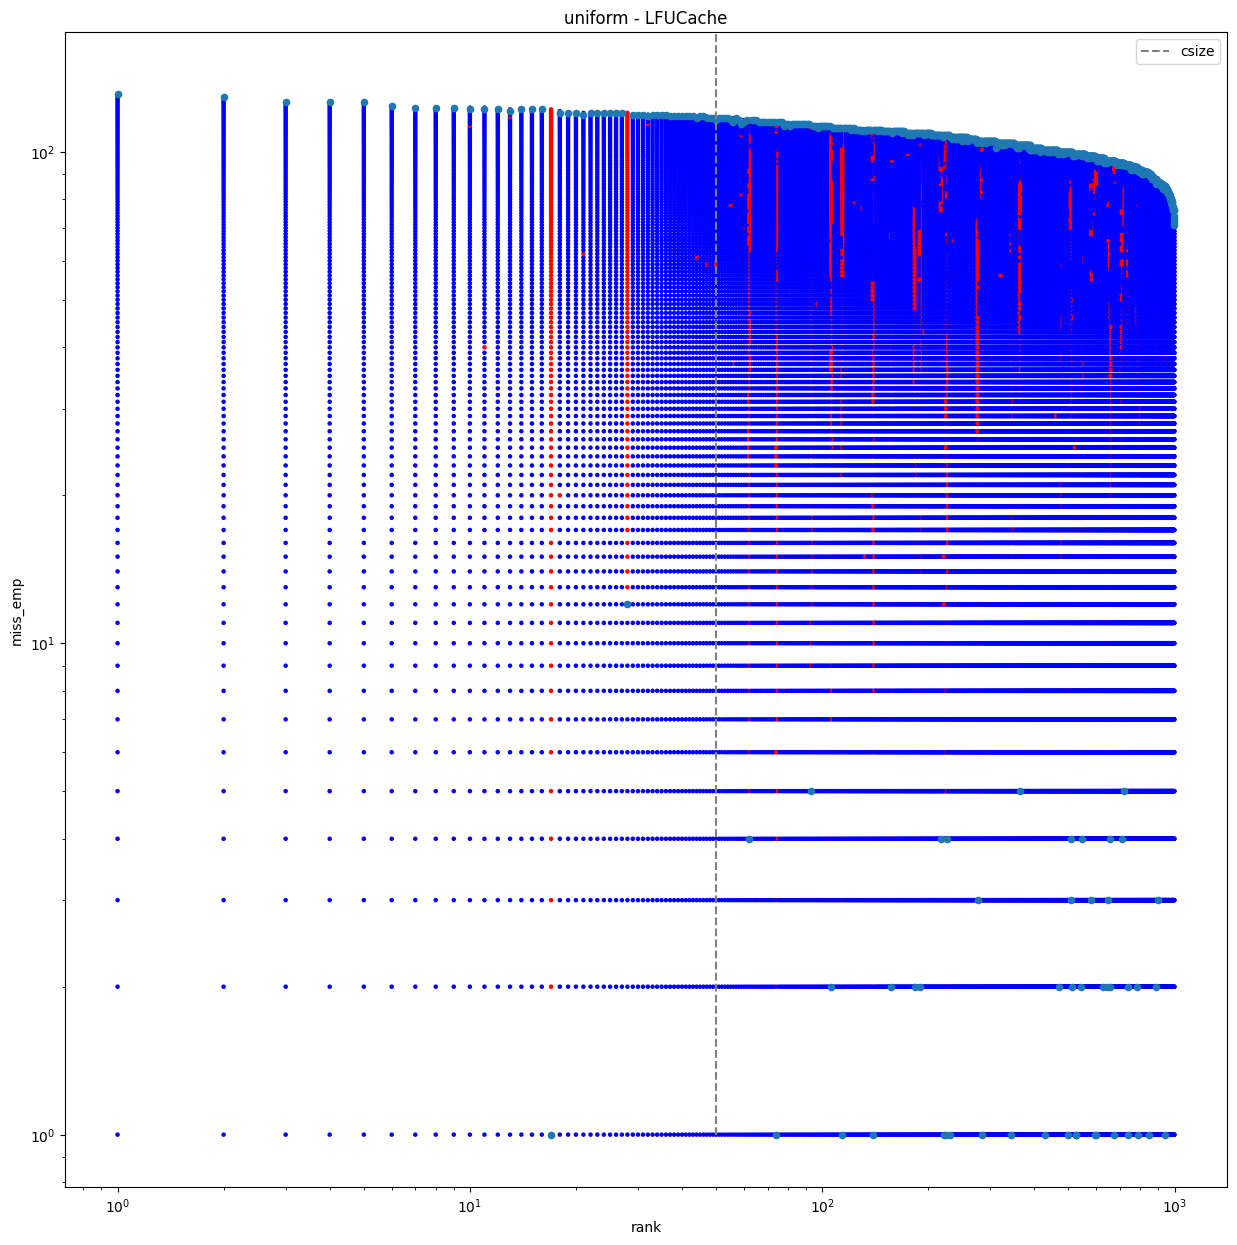

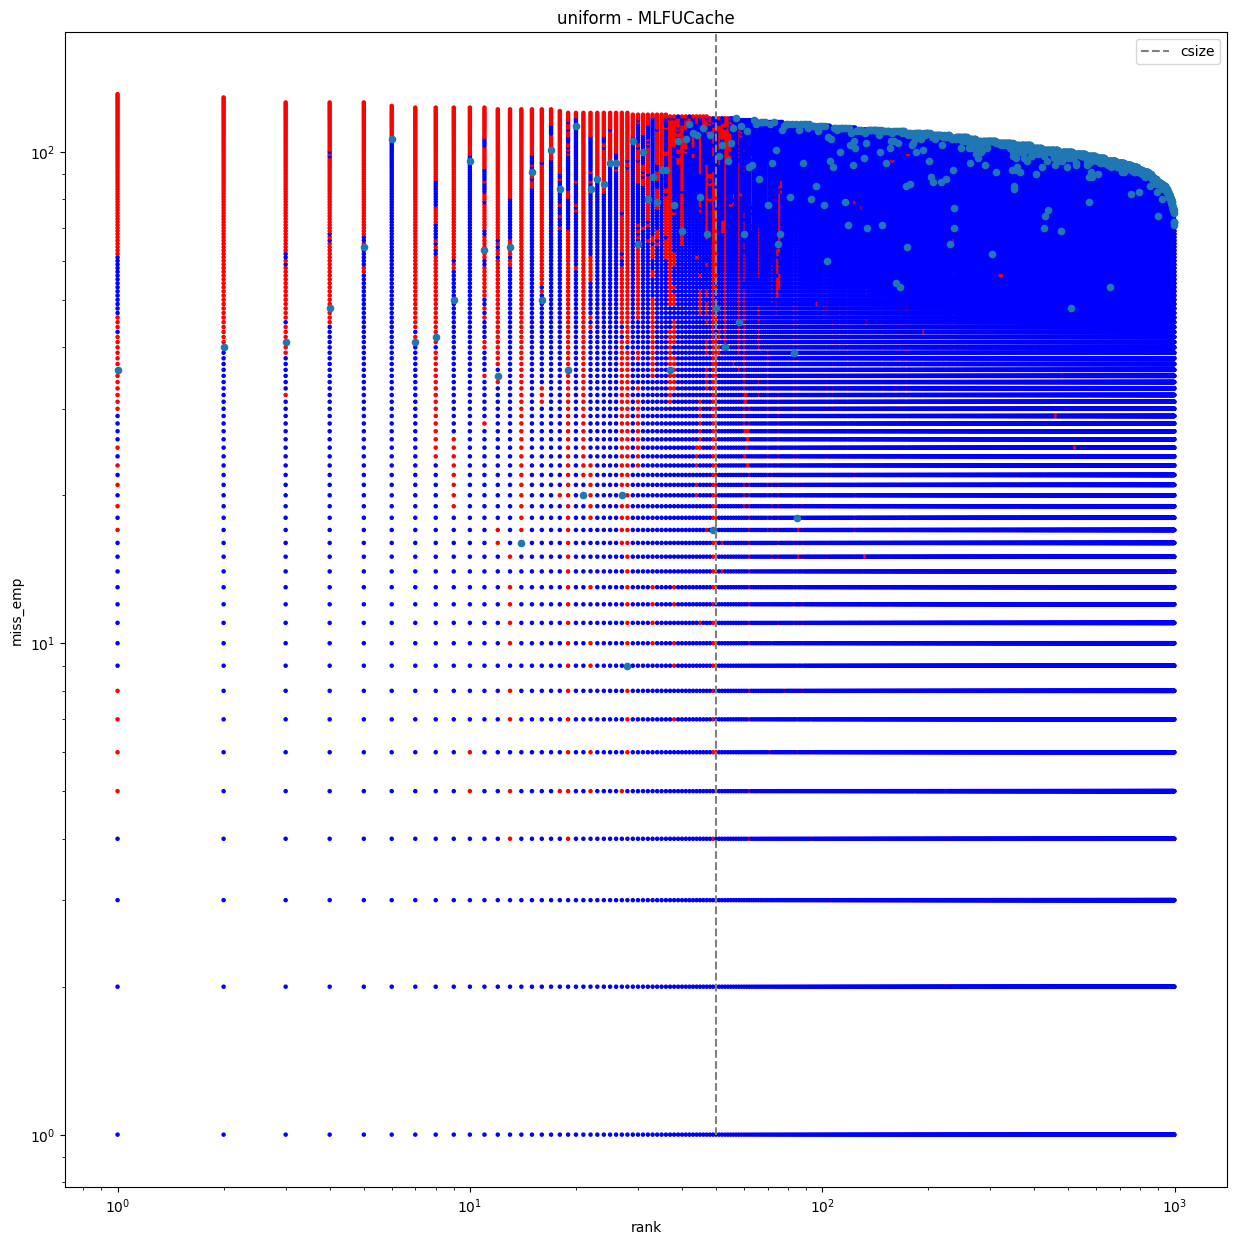

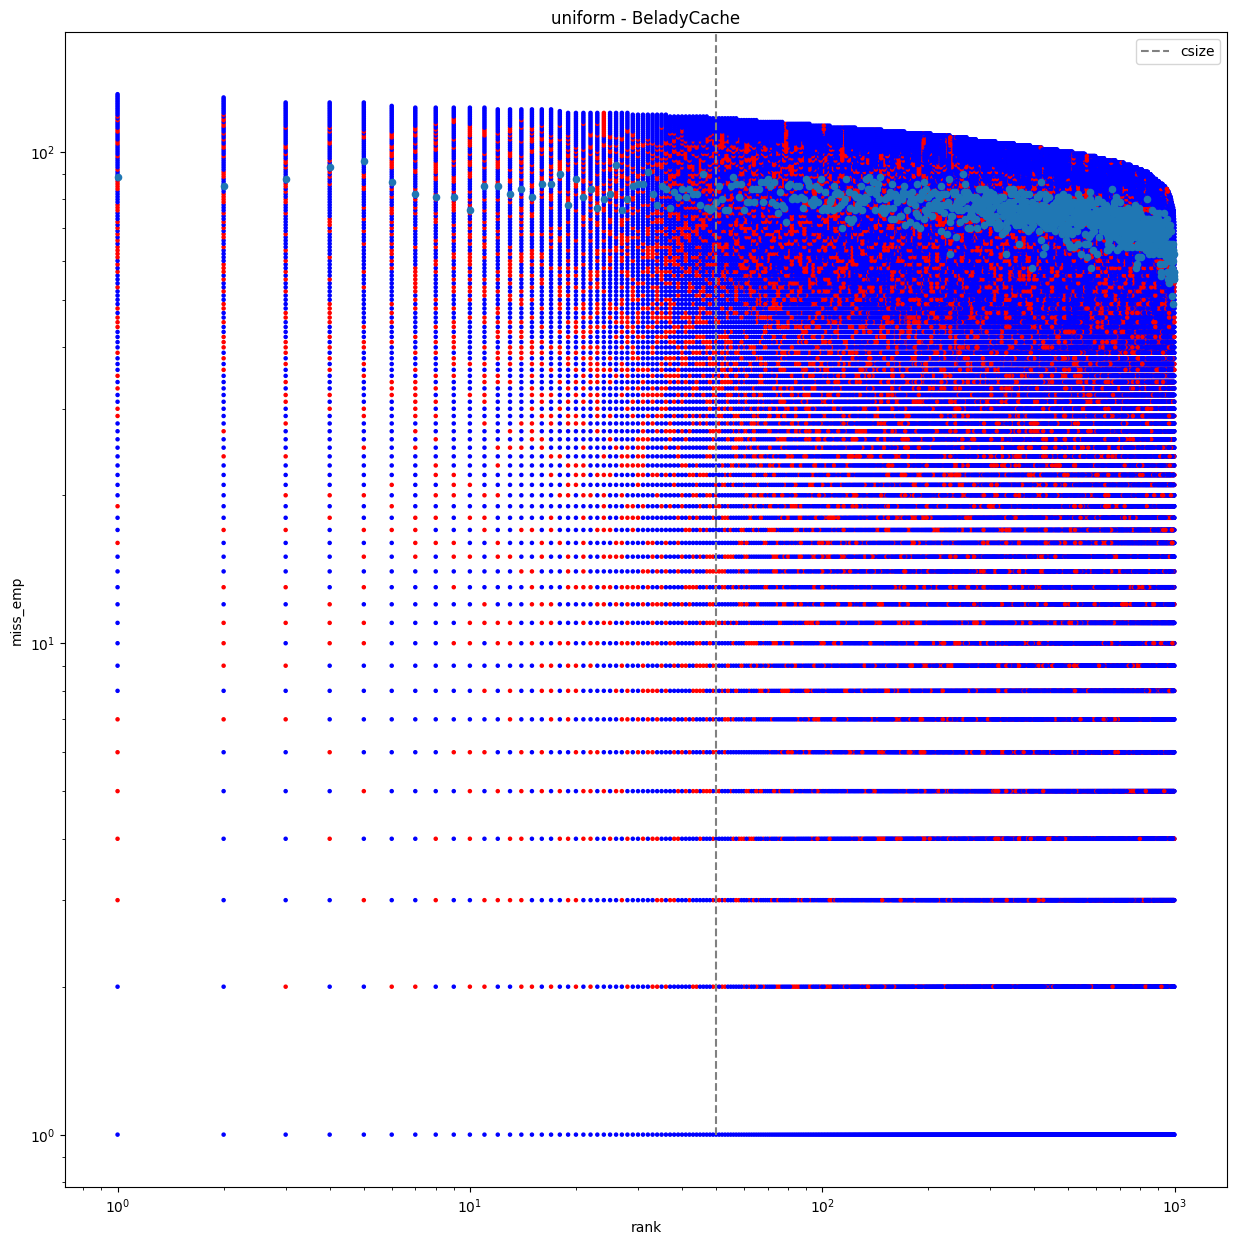

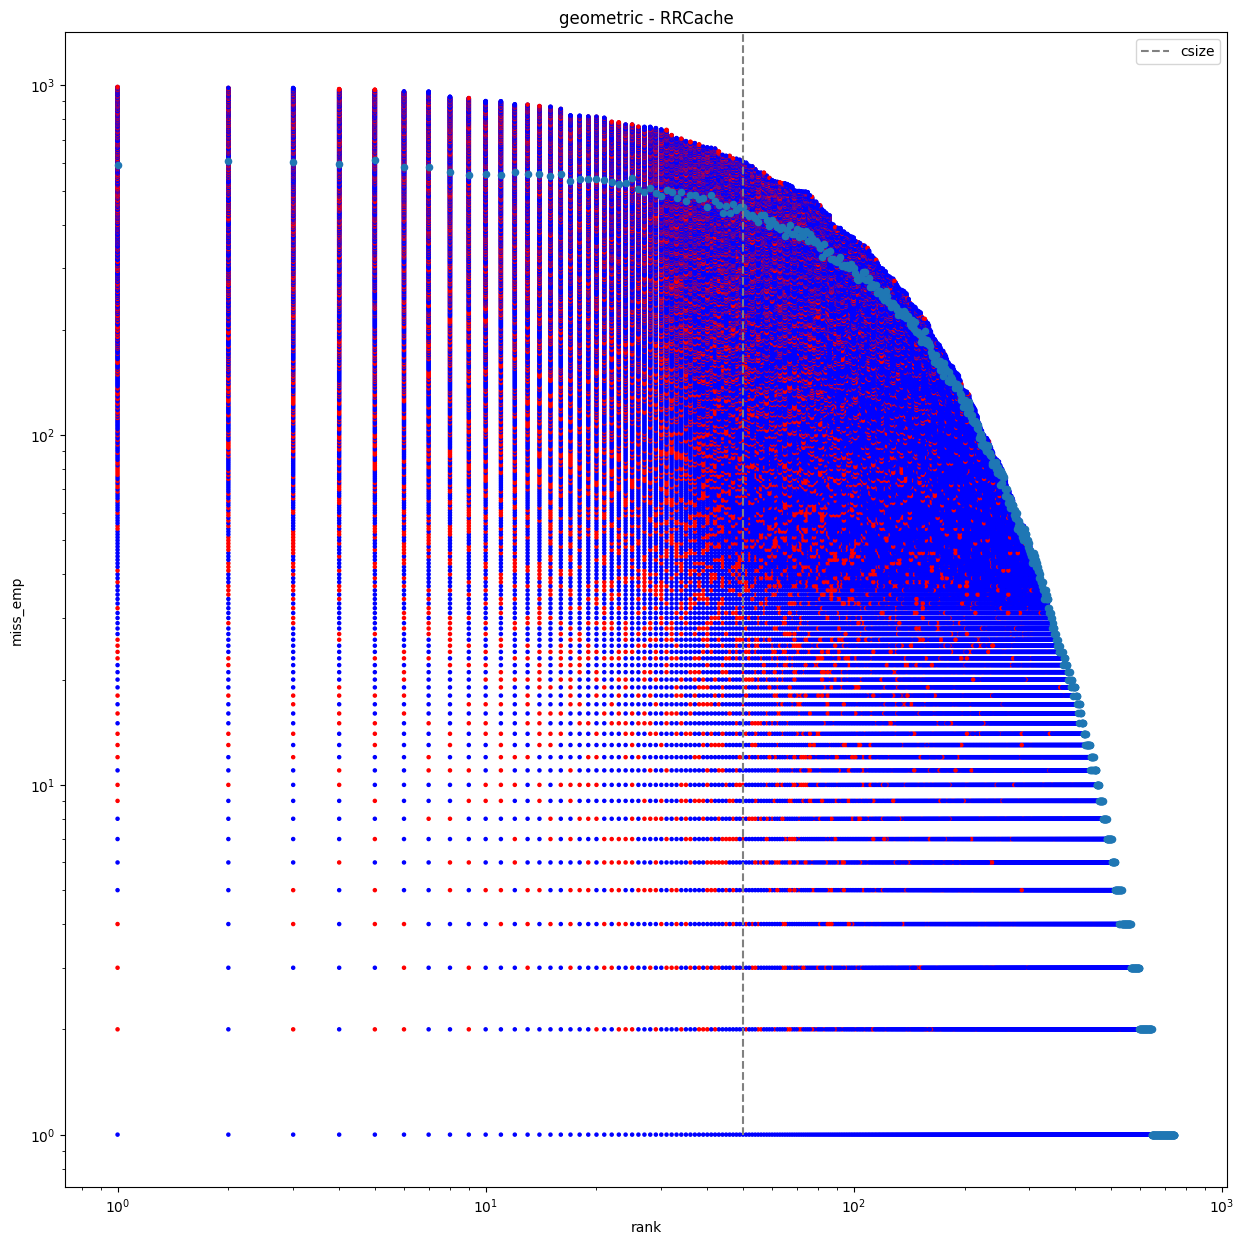

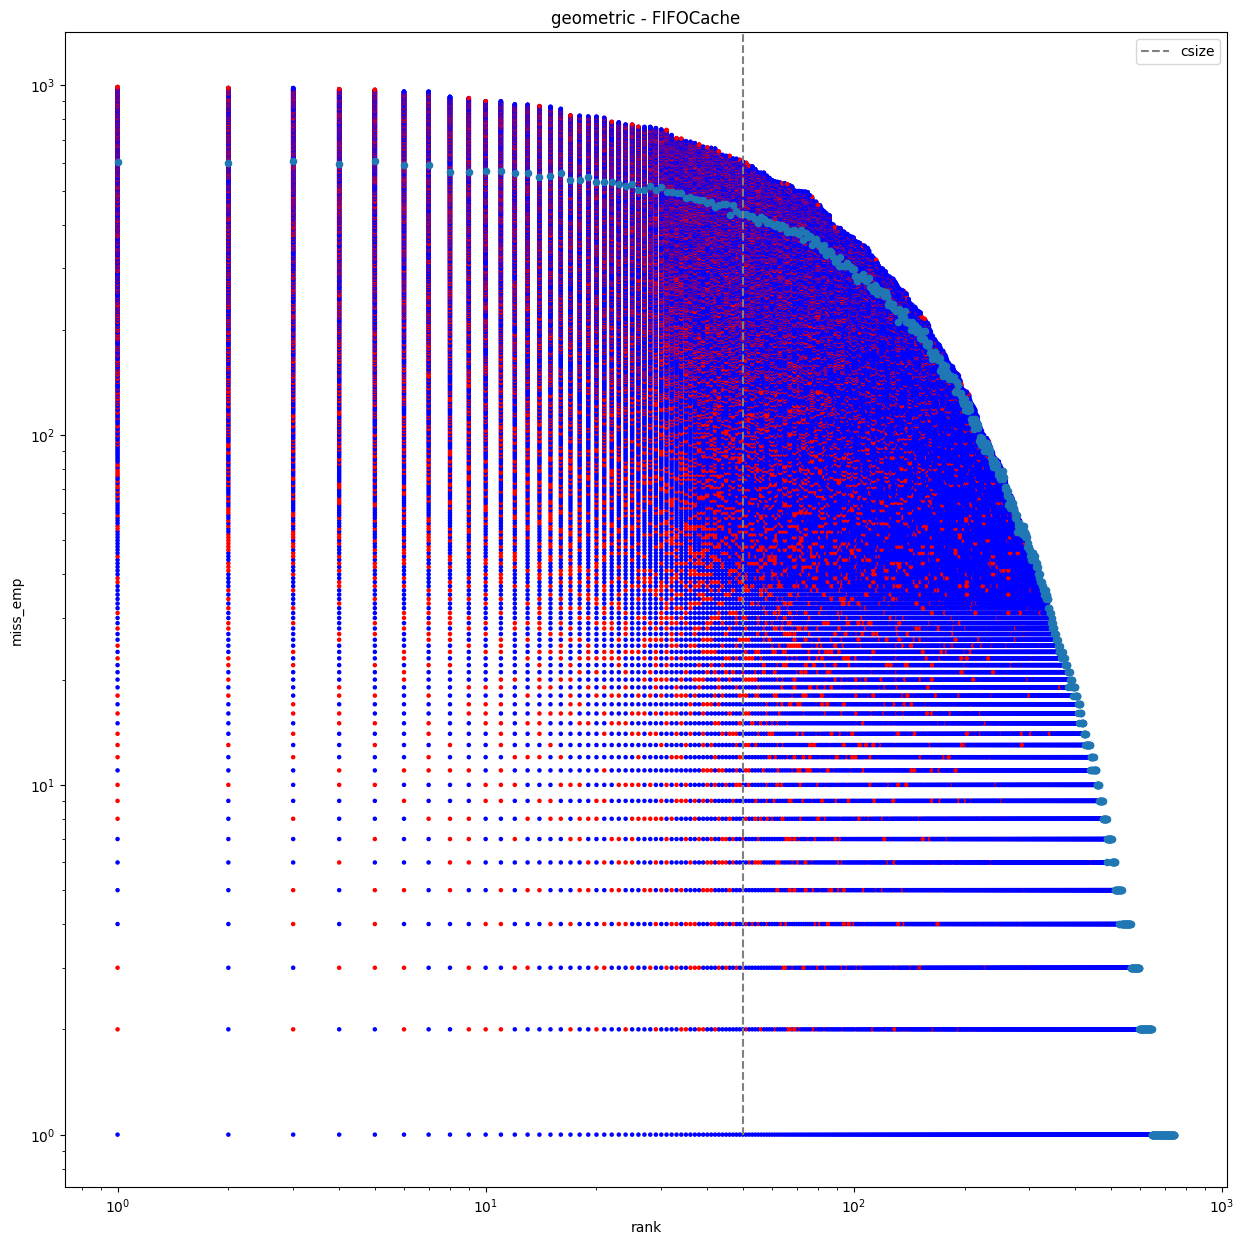

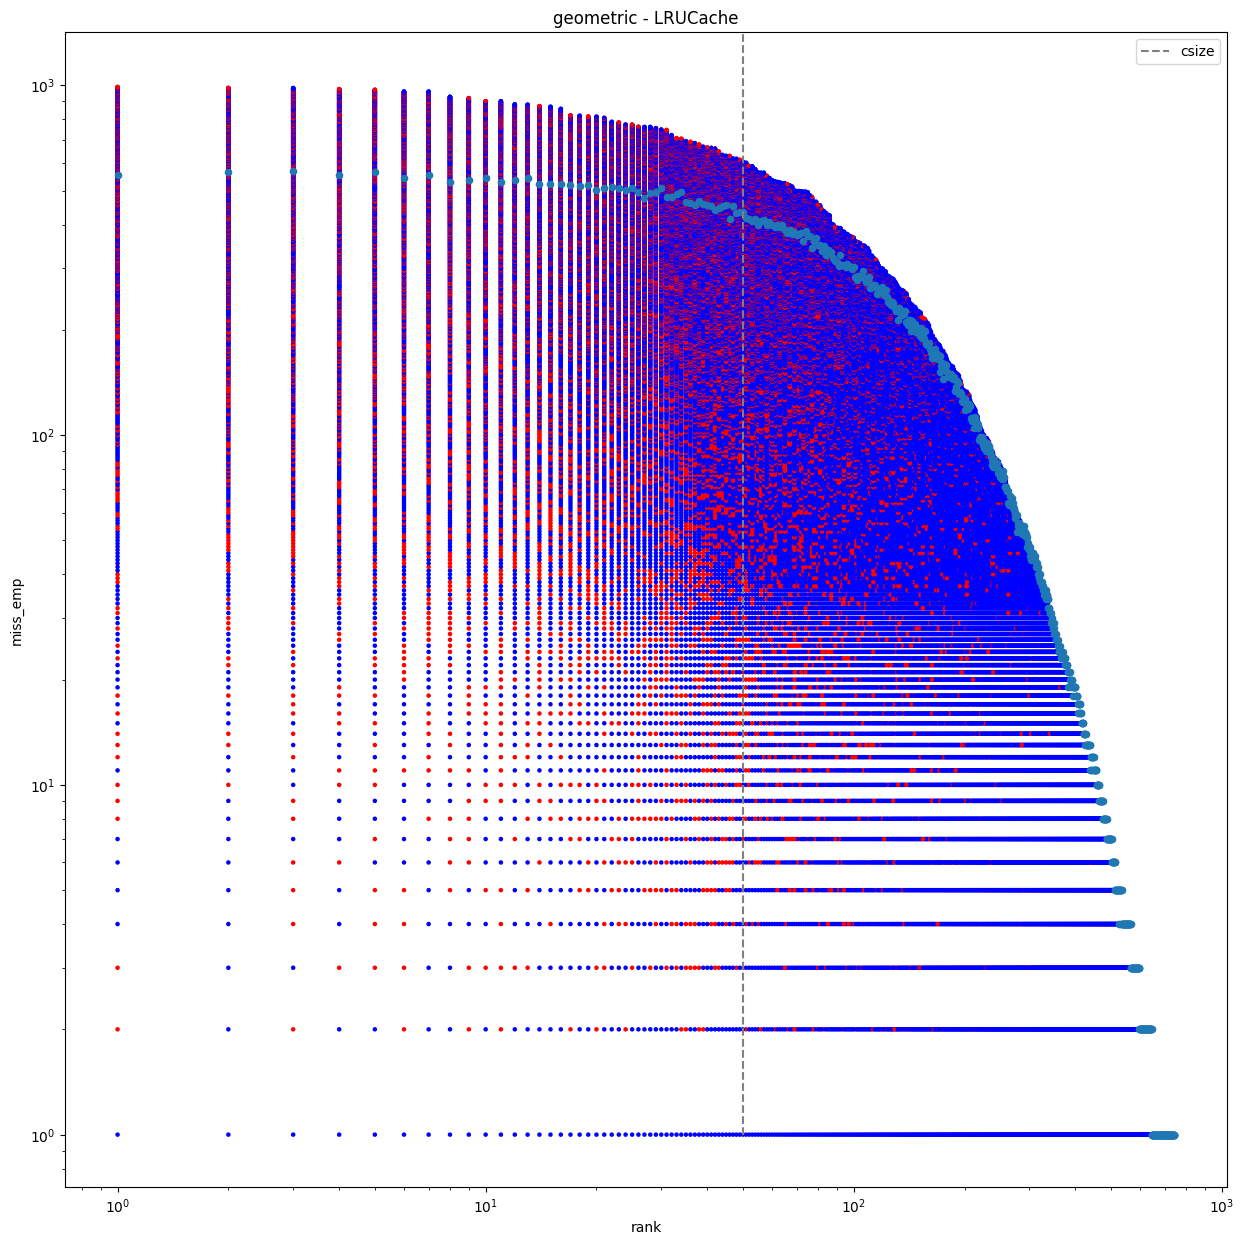

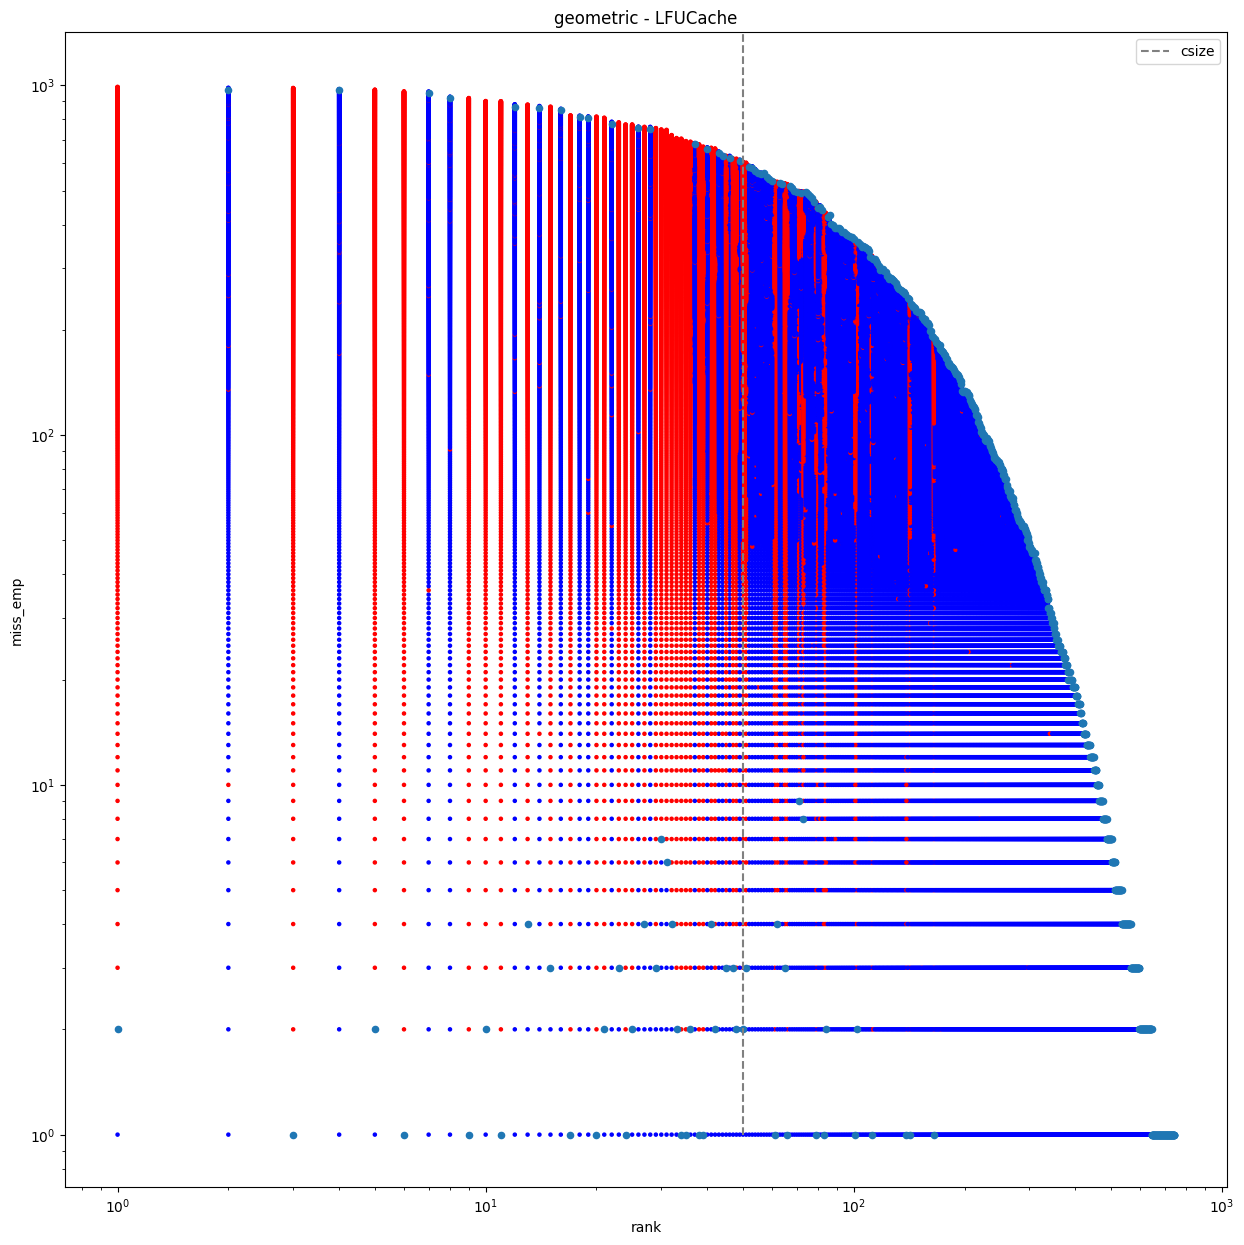

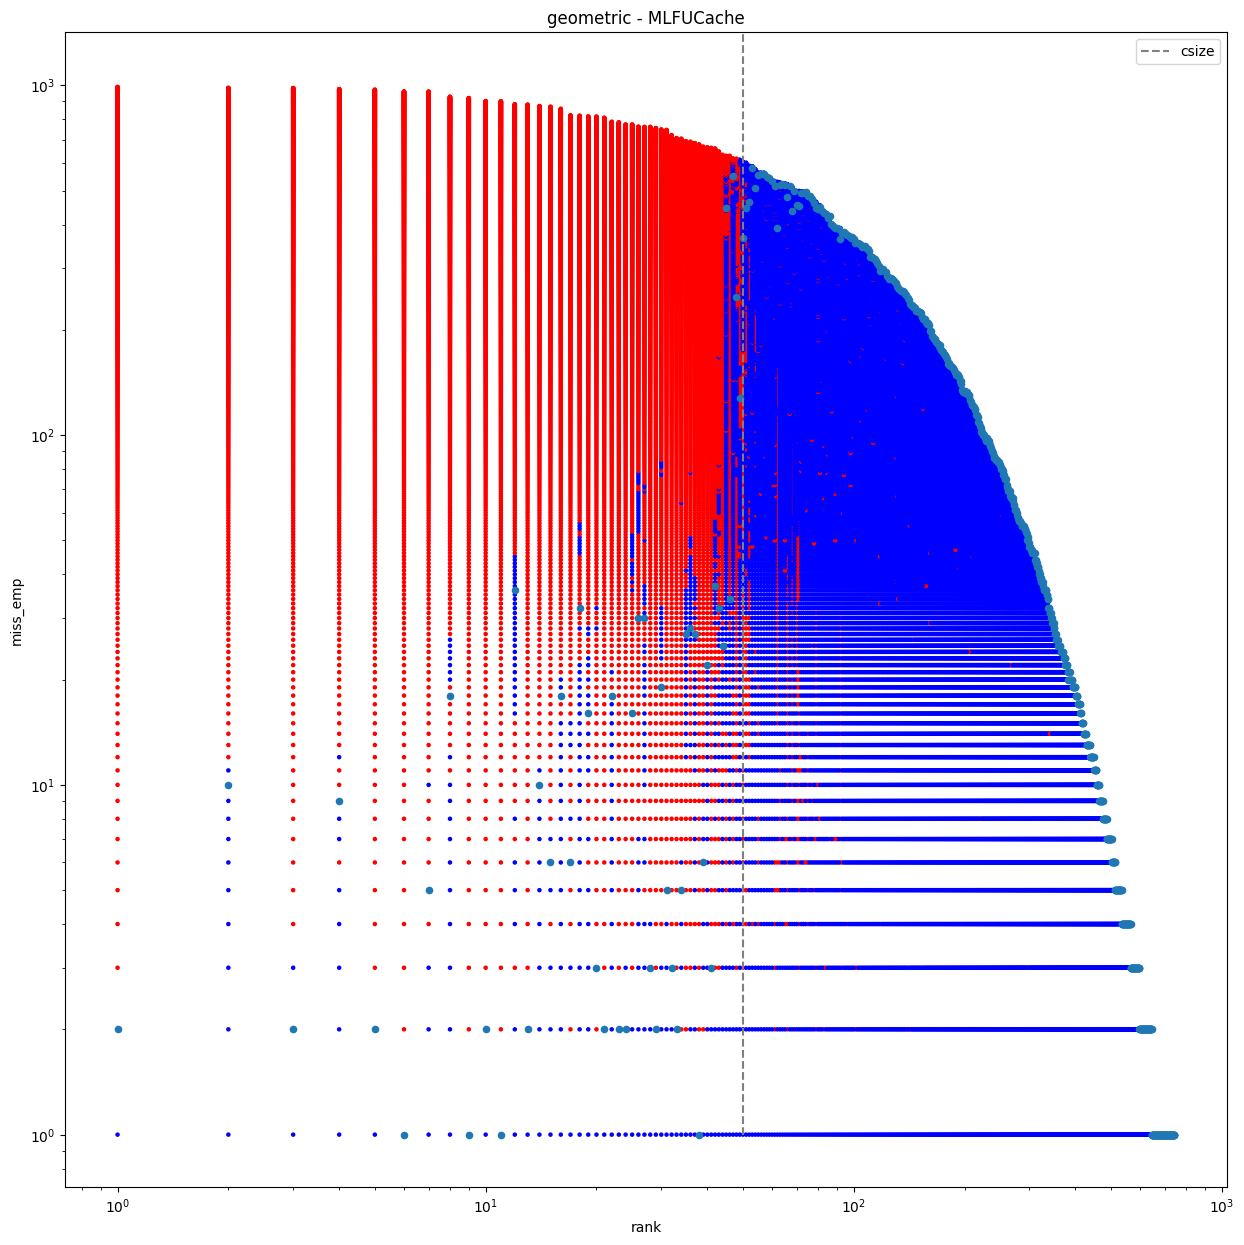

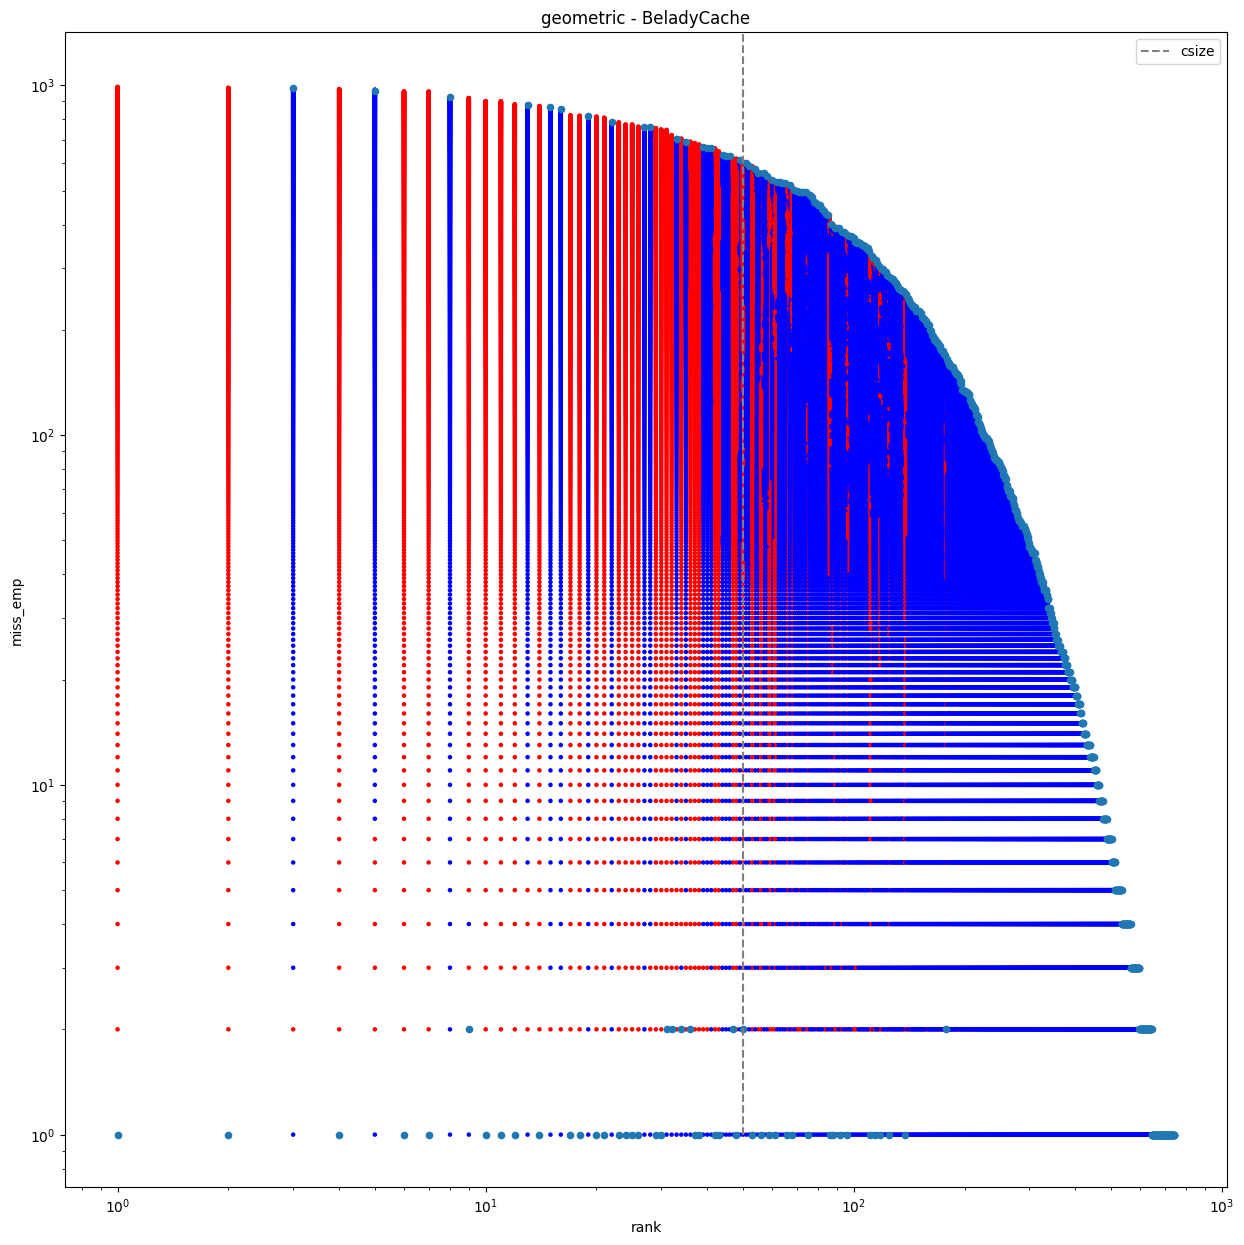

In [21]:
for distr, weights in {'zipf': [zipf_pmf(k, s) for k in keys], 'uniform': [1] * cbase,
                       'geometric': [geometric_pmf(k, p) for k in keys]}.items():
    requests = random.choices(keys, weights=weights, k=n)
    timestamps = list(range(n))

    for cache in [RRCache(maxsize=size), FIFOCache(maxsize=size), LRUCache(maxsize=size), LFUCache(maxsize=size),
                  MLFUCache(maxsize=size), BeladyCache(maxsize=size, future=requests)]:

        name = f"{distr} - {cache.__class__.__name__}"

        @mycached(cache=cache)
        def storage(time, key) -> None:
            return None


        assert n == len(requests), f"{len(requests)}"

        for timestamp, key in zip(timestamps, requests):
            storage(timestamp, key)

        assert storage.nrequests() == n, f"requests missmatch {storage.nrequests()}"

        df = storage.df()

        # calculate ranks
        df_ranks = pd.DataFrame(df.index.value_counts().index).reset_index(names='rank').set_index('key')

        # join with ranks
        df = df.join(df_ranks)
        assert df.shape[0] == n
        assert not df.isnull().values.any()

        # add ccount
        df['ccount'] = df.groupby('rank').cumcount() + 1
        assert df.shape[0] == n
        assert not df.isnull().values.any()

        df['color'] = df['hit'].apply(lambda h: 'red' if h else 'blue')

        # calculate miss curve
        df_miss = df.groupby(['hit', 'rank']).count().rename({'ccount': 'miss_emp'}, axis='columns').loc[False]
        #df_miss['miss_emp_ma'] = df_miss.rolling(10).mean()
        #df_miss['miss_the'] = df_miss.index.map(lambda k: zipf_pmf(k) * n if k > maxsize else 0)
        #df_miss['error'] = (df_miss['miss_the'] - df_miss['miss_emp_ma']).abs()

        _fig, ax = plt.subplots(figsize=(15, 15))
        df.plot.scatter(ax=ax, x='rank', y='ccount', loglog=True, c='color', marker='.', figsize=(15, 15), title=name)
        df_miss.reset_index().plot.scatter(ax=ax, x='rank', y='miss_emp', loglog=True)
        #df_miss.reset_index().plot(ax=ax, x='rank', y='miss_emp_ma', loglog=True)
        ax.vlines(cache.maxsize, ymin=1, ymax=n, colors='grey', label="csize", linestyles='--')
        plt.legend()
        #    ('rank', 'ccount', data=df, s='.')
        # cache size
        #    plt.vlines(maxsize, ymin=1, ymax=10**5, colors='grey', label="csize", linestyles='--')

        #df_miss.plot(logy=True, ylim=(1, 10 ** 5))
        plt.savefig(f"out/{name}.png")


        #print(f"{distr} - {cache.__class__.__name__}, {storage.chr() * 100:.2f}%")
